In [0]:
!pip install --upgrade pandas

In [0]:
!pip install --upgrade sklearn

In [0]:
!pip install bokeh plotly
%load_ext autoreload

In [0]:
!pip install cufflinks --upgrade

In [204]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from os import path
from sklearn.decomposition import SparsePCA, PCA
from sklearn.preprocessing import scale, normalize
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.manifold import MDS
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import Lasso
from bokeh.plotting import figure, output_notebook, show

In [411]:
import personality
reload(personality)
from personality import *

In [268]:
X = prep_X(read_surveys())
one = X.iloc[:, 0:65]
others = X.iloc[:, 65:]

bigfive_key = pd.read_csv("educatalyst/Auxil/q1_key_bigfive.csv")
bigfive = big_five_projection(bigfive_key, one)
bigfive_scaled = big_five_projection(bigfive_key, one, True)
bf_comps = get_big_five_comps(bigfive_key)

In [126]:
dist_one = scale(pairwise_distances(one, metric = "l2"))
dist_others = scale(pairwise_distances(others, metric = "l2"))
dist_all = scale(pairwise_distances(X, metric = "l2"))
dist_f_all = scale(pairwise_distances(projected, metric = "l2"))
dist_five = scale(pairwise_distances(bigfive, metric = 'l2'))

ids = read_surveys().user_id

In [418]:
cv = KFold(3, random_state = 1, shuffle = True)
t = bigfive_scaled.as_matrix()[:, [0,1,2,4]]
m = GridSearchCV(MultiElasticNet(), {'alpha': np.arange(0.05, 1.5, .05), 'l1_ratio': np.arange(0.2, 1.0, .05)}, cv = cv, scoring='neg_mean_squared_error')
res = pd.DataFrame(m.fit(others, t).cv_results_)

In [0]:
res[res.mean_test_score > np.percentile(res.mean_test_score, 85) ].sort_values(['param_l1_ratio', 'param_alpha'], ascending = False)[['params', 'mean_test_score']].head(20)

In [0]:
m.best_score_, m.best_params_

In [0]:
# using the most agressive sparsity-inducing params from the top 15% cv'd scores
enet = MultiElasticNet(alpha = 0.5, l1_ratio = .45)
t = bigfive_scaled.as_matrix()
fitted = enet.fit(others, t)
reg_comps = normalize(enet.coef_).T
cross_val_score(enet, others, t, cv = cv, scoring = 'neg_mean_squared_error').mean(), enet.coef_

In [428]:
cross_val_score(enet, others, t, cv = cv)

array([ 0.40848236,  0.38958667,  0.41716287])

In [426]:
# do we want correlation coef or pvalue????? Is this bad or good??? 
compare_factors(one, bf_comps, others, reg_comps)

[KendalltauResult(correlation=0.47871084292415123, pvalue=8.2295975694679451e-12),
 KendalltauResult(correlation=0.52736043937772448, pvalue=5.110838060824591e-14),
 KendalltauResult(correlation=0.60393884155313315, pvalue=6.5590379159161044e-18),
 KendalltauResult(correlation=0.37691270407252497, pvalue=7.4018268224004627e-08),
 KendalltauResult(correlation=0.59429933739540408, pvalue=2.1621252247850352e-17)]

In [259]:
normed_reg_vectors = normalize(enet.coef_).T
projected = others.dot(normed_reg_vectors)
np.var(projected)

0    4.130844
1    3.815130
2    4.072245
3    2.867041
4    3.706479
dtype: float64

In [429]:
pca_others = SparsePCA(5, .5).fit(others)
projected_pca_others = others.dot(normalize(pca_others.components_).T)
np.var(projected_pca_others)

0    2.624397
1    7.593051
2    4.415897
3    3.427975
4    3.365724
dtype: float64

In [431]:
pca_one = SparsePCA(5, .5).fit(one)
projected = one.dot(normalize(pca_one.components_).T)
np.var(projected)

0    6.837325
1    9.942295
2    4.853767
3    4.834003
4    8.344890
dtype: float64

In [262]:
projected = one.dot(bf_comps)
np.var(projected)

0    5.968033
1    4.620225
2    5.464298
3    3.735383
4    7.075983
dtype: float64

In [138]:
dist_scaled = pairwise_distances(bigfive, metric = 'mahalanobis')
dist_five2 = pairwise_distances(bigfive_scaled, metric = 'mahalanobis')
get_diff(dist_scaled, dist_five2)

0.035187536092504995

In [0]:
sns.stripplot(x = 'value', y = 'variable', data = bigfive.melt(), orient = 'h')

In [0]:
sns.stripplot(x = 'value', y = 'variable', data = bigfive_scaled.melt(), orient = 'h')

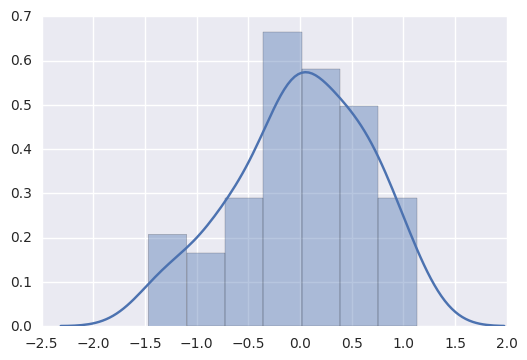

In [432]:
# take a look at the questions on the axes...
(np.sign(np.round(model.components_[0]/5)))

# Look at just the answers to the bigfive problems
one = X.iloc[:, 0:65]

sns.distplot(one.apply(np.mean, 0))